# Tuberculosis / Pneumonia / Normal X-Ray Classifier (Keras)

This notebook follows your previous TB-vs-Normal style with explicit folder paths and a dataframe-based loader. It trains a **3-class** CNN (Normal, Tuberculosis, Pneumonia).

## 0) Environment Check

In [ ]:
import sys, platform, tensorflow as tf
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
TensorFlow: 2.20.0
GPU Available: []


## 1) Imports

In [ ]:
!pip install tensorflow


  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached ml_dtypes-0.5.3-cp310-cp310-win_amd64.whl (206 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
  Using cached grpcio-1.74.0-cp310-cp310-win_amd64.whl (4.5 MB)
  Using cached keras-3.11.2-py3-none-any.whl (1.4 MB)
  Using cached termcolor-3.1.0-py3-none-any.whl (7.7 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl (135 kB)
  Using cached wrapt-1.17.3-cp310-cp310-win_amd64.whl (38 kB)
  Using cached h5py-3.14.0-cp310-cp310-win_amd64.whl (2.9 MB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
  Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
  Using cached namex-0.1.0-py3-none-any.whl (5.9 kB)
  Using cached rich-14.1.0-py3-none-any.whl (243 kB)
  Using cached optree-0.17.0-cp310-cp310-win_amd64.whl (304 k

In [ ]:
import os
import cv2
import io
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image

## 2) Set Paths
Update the base path if needed. The three class folders must exist:
`Normal`, `Tuberculosis`, `Pneumonia`.

In [ ]:

# ==== EDIT THIS IF YOUR PATHS DIFFER ====
#Ffrom pathlib import Path
# base_path = Path("C:/Users/DELL/Downloads/archive/TB_Chest
base_path = r"TB_Chest_Radiography_Database"
# construct full paths for each class

Normalpath     = str(Path(base_path) / "Normal")
TBpath         = str(Path(base_path) / "Tuberculosis")
Pneumoniapath  = str(Path(base_path) / "Pneumonia")
# Constants

CLASS_ORDER = ["Normal", "Tuberculosis", "Pneumonia"]  # keep this order consistent everywhere
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32

# Check if paths exist

for p in [Normalpath, TBpath, Pneumoniapath]:
    print(p, "->", "OK" if Path(p).exists() else "NOT FOUND")


TB_Chest_Radiography_Database\Normal -> OK
TB_Chest_Radiography_Database\Tuberculosis -> OK
TB_Chest_Radiography_Database\Pneumonia -> OK


In [ ]:
from pathlib import Path
base_path = ("TB_Chest_Radiography_Database")
paths = {
"Normal": Path(base_path) / "Normal",
"Tuberculosis":Path(base_path) / "Tuberculosis",
"Pneumonia":Path(base_path) / "Pneumonia"
}
for i , ( label , path ) in enumerate(paths.items()):
    status = "OK" if path.exists() else "NOT FOUND"
    print(f"{i+1}. {label} path: {path} -> {status}")



1. Normal path: TB_Chest_Radiography_Database\Normal -> OK
2. Tuberculosis path: TB_Chest_Radiography_Database\Tuberculosis -> OK
3. Pneumonia path: TB_Chest_Radiography_Database\Pneumonia -> OK


## 3) Build File List (DataFrame)

Number of TB images: 700
Number of Normal images: 3500
Number of Pneumonia images: 4266


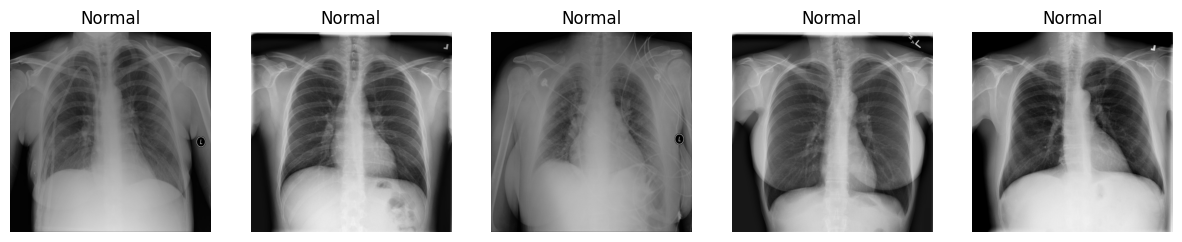

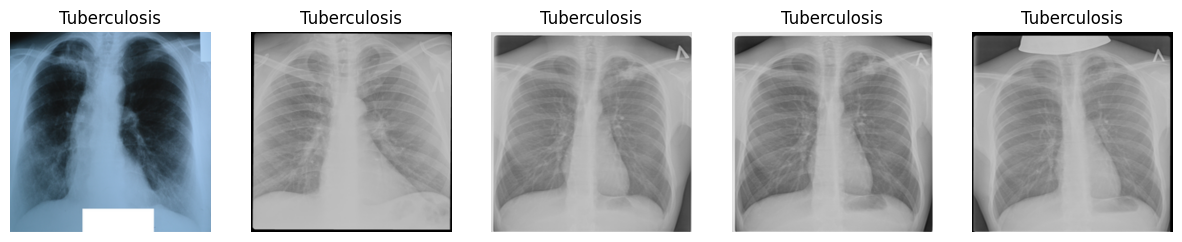

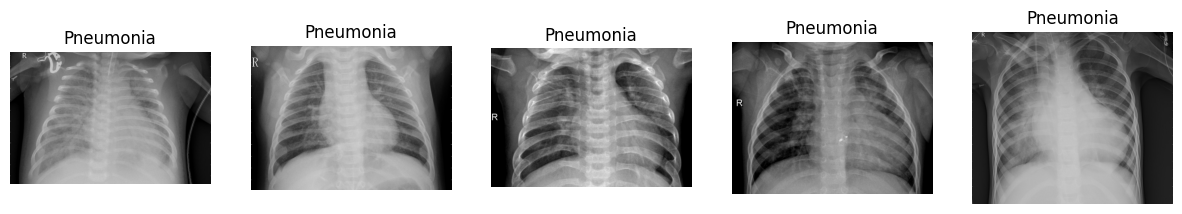

In [ ]:
print("Number of TB images:", len(os.listdir(TBpath)))
print("Number of Normal images:", len(os.listdir(Normalpath)))
print("Number of Pneumonia images:", len(os.listdir(Pneumoniapath)))

def show_examples(class_path, title, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15,5))
    for i, fname in enumerate(os.listdir(class_path)[:n]):
        img = cv2.imread(os.path.join(class_path, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title)
    plt.show()

show_examples(Normalpath, "Normal")
show_examples( TBpath, "Tuberculosis")
show_examples(Pneumoniapath, "Pneumonia")

In [ ]:

def list_images(folder, label):
    folder = Path(folder)
    exts = ("*.png","*.jpg","*.jpeg","*.bmp")
    files = []
    for e in exts:
        files += [str(p) for p in folder.glob(e)]
        files += [str(p) for p in folder.glob(e.upper())]
    return pd.DataFrame({"filepath": files, "label": label})

df = pd.concat([
    list_images(Normalpath, "Normal"),
    list_images(TBpath, "Tuberculosis"),
    list_images(Pneumoniapath, "Pneumonia"),
], ignore_index=True)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.head())
print("Counts:\n", df.label.value_counts())


                                            filepath         label
0  TB_Chest_Radiography_Database\Tuberculosis\Tub...  Tuberculosis
1  TB_Chest_Radiography_Database\Pneumonia\person...     Pneumonia
2  TB_Chest_Radiography_Database\Normal\Normal-13...        Normal
3  TB_Chest_Radiography_Database\Pneumonia\person...     Pneumonia
4  TB_Chest_Radiography_Database\Pneumonia\person...     Pneumonia
Counts:
 label
Pneumonia       8530
Normal          7000
Tuberculosis    1400
Name: count, dtype: int64


In [ ]:
from pathlib import Path
import cv2
import pandas as pd

def list_images(folder, label):
    folder = Path(folder)
    exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp")
    files = []
    for e in exts:
        files += list(folder.glob(e))
        files += list(folder.glob(e.upper()))

    valid_files = []
    for f in files:
        img = cv2.imread(str(f))
        if img is not None:
            valid_files.append(str(f))  # Ensure it's a string for DataFrame

    return pd.DataFrame({"filepath": valid_files, "label": label})

# Check if paths exist
print("Normal path exists:", Path(Normalpath).exists())
print("TB path exists:", Path(TBpath).exists())
print("Pneumonia path exists:", Path(Pneumoniapath).exists())

# Preview each class
print(list_images(Normalpath, "Normal").head())
print(list_images(TBpath, "Tuberculosis").head())
print(list_images(Pneumoniapath, "Pneumonia").head())

Normal path exists: True
TB path exists: True
Pneumonia path exists: True
                                            filepath   label
0  TB_Chest_Radiography_Database\Normal\Normal-1.png  Normal
1  TB_Chest_Radiography_Database\Normal\Normal-10...  Normal
2  TB_Chest_Radiography_Database\Normal\Normal-10...  Normal
3  TB_Chest_Radiography_Database\Normal\Normal-10...  Normal
4  TB_Chest_Radiography_Database\Normal\Normal-10...  Normal
                                            filepath         label
0  TB_Chest_Radiography_Database\Tuberculosis\Tub...  Tuberculosis
1  TB_Chest_Radiography_Database\Tuberculosis\Tub...  Tuberculosis
2  TB_Chest_Radiography_Database\Tuberculosis\Tub...  Tuberculosis
3  TB_Chest_Radiography_Database\Tuberculosis\Tub...  Tuberculosis
4  TB_Chest_Radiography_Database\Tuberculosis\Tub...  Tuberculosis
                                            filepath      label
0  TB_Chest_Radiography_Database\Pneumonia\person...  Pneumonia
1  TB_Chest_Radiography_Databa

## 4) Train / Validation Split (Stratified)

In [ ]:

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df.label
)
print("Train:", train_df.shape, "Val:", val_df.shape)


Train: (13544, 2) Val: (3386, 2)


## 5) Generators (`flow_from_dataframe`)

In [ ]:

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col="filepath", y_col="label",
    target_size=IMG_SIZE,
    classes=CLASS_ORDER,           # fixed explicit order
    class_mode="categorical",      # 3-class
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col="filepath", y_col="label",
    target_size=IMG_SIZE,
    classes=CLASS_ORDER,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Class indices:", train_data.class_indices)


Found 13544 validated image filenames belonging to 3 classes.
Found 3386 validated image filenames belonging to 3 classes.
Class indices: {'Normal': 0, 'Tuberculosis': 1, 'Pneumonia': 2}


## 6) Model (Simple CNN Head)
Swap this with your preferred backbone if needed; just keep the final Dense(3, softmax).

In [ ]:

model = Sequential([
    Input(shape=IMG_SIZE + (3,)),
    Conv2D(32, (3,3), activation='relu'), MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'), MaxPooling2D(),
    Conv2D(128,(3,3), activation='relu'), MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## 7) (Optional) Class Weights for Imbalance

In [ ]:

use_class_weights = False  # set True to enable

cw = None
if use_class_weights:
    counts = Counter(train_data.classes)
    total = sum(counts.values())
    cw = {i: total/(len(counts)*counts[i]) for i in counts}
    print("Class weights:", cw)


## 8) Train

In [ ]:

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=cw
)


c:\Users\TecFielD\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 282s 660ms/step - accuracy: 0.9030 - loss: 0.2708 - val_accuracy: 0.8819 - val_loss: 0.3384
Epoch 2/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 278s 656ms/step - accuracy: 0.9424 - loss: 0.1619 - val_accuracy: 0.9669 - val_loss: 0.0960
Epoch 3/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 302s 713ms/step - accuracy: 0.9627 - loss: 0.1082 - val_accuracy: 0.9640 - val_loss: 0.0913
Epoch 4/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 311s 732ms/step - accuracy: 0.9636 - loss: 0.1048 - val_accuracy: 0.9781 - val_loss: 0.0651
Epoch 5/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 300s 706ms/step - accuracy: 0.9687 - loss: 0.0949 - val_accuracy: 0.9767 - val_loss: 0.0773


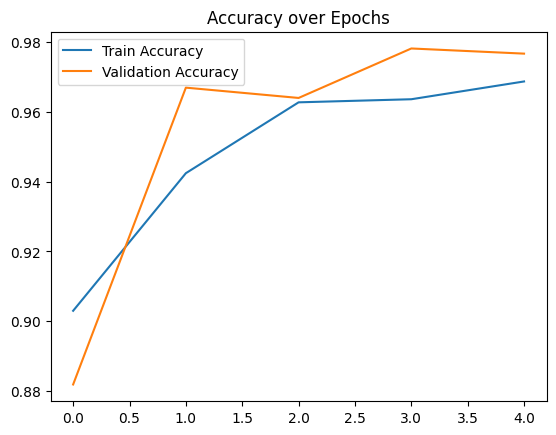

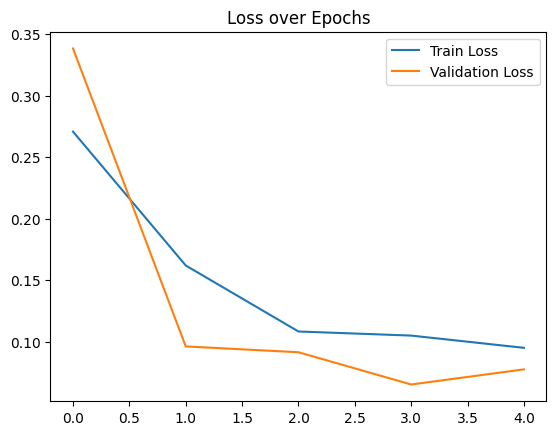

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

#**Save The Model**

In [ ]:
model.save("TuberPneu_model.h5")

## 9) Evaluate: Confusion Matrix & Report

              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97      1400
Tuberculosis       0.99      0.77      0.87       280
   Pneumonia       0.99      1.00      0.99      1706

    accuracy                           0.98      3386
   macro avg       0.98      0.92      0.95      3386
weighted avg       0.98      0.98      0.98      3386



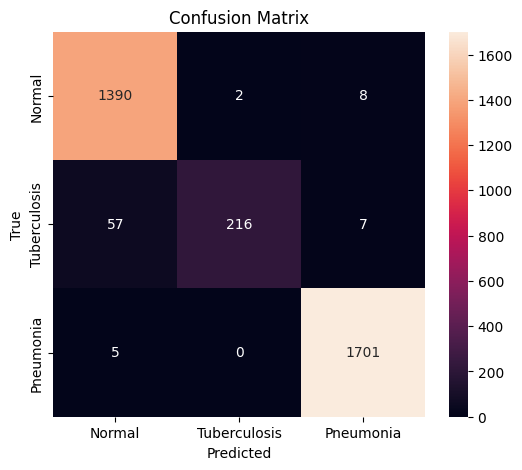

In [ ]:

y_true = val_data.classes
probs  = model.predict(val_data, verbose=0)
y_pred = np.argmax(probs, axis=1)
labels = CLASS_ORDER

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()


In [ ]:
# Required imports for the tuberculosis detection notebook
import numpy as np
import matplotlib.pyplot as plt
import io
from PIL import Image
from pathlib import Path

# TensorFlow/Keras imports
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Jupyter widgets imports
import ipywidgets as widgets
from IPython.display import display, clear_output

# Optional: Set matplotlib to display plots inline
%matplotlib inline





# Load model
model = load_model("TuberPneu_model.h5")

# UI widgets
uploader = widgets.FileUpload(accept='image/*', multiple=False)
predict_button = widgets.Button(description="🔍 Predict")
filename_label = widgets.Label(value="No file uploaded")
output = widgets.Output()

# Display UI
display(widgets.HTML("<h3>📁 Upload a chest X-ray image</h3>"))
display(uploader, filename_label, predict_button, output)

# Update filename when a file is uploaded
def on_upload(change):
    if uploader.value:
        uploaded_file = uploader.value[0]
        filename_label.value = f"📄 File: {uploaded_file['name']}"

uploader.observe(on_upload, names='value')

# Predict image
def predict_image(change):
    with output:
        clear_output()
        if uploader.value:
            uploaded_file = uploader.value[0]
            image_data = uploaded_file['content']
            image = Image.open(io.BytesIO(image_data)).convert('RGB')

            image_resized = image.resize((224, 224))
            img_array = img_to_array(image_resized)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            prediction = model.predict(img_array)[0][0]
            label = "Tuberculosis" if prediction > 0.5 else "Normal"
            confidence = prediction if prediction > 0.5 else (1 - prediction)

            if label == "Tuberculosis":
                if confidence > 0.90:
                    stage = "Advanced stage"
                elif confidence > 0.70:
                    stage = "Intermediate stage"
                else:
                    stage = "Early stage"
            else:
                stage = "N/A"

            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Prediction: {label} ({confidence*100:.2f}%)\nStage: {stage}")
            plt.show()
        else:
            print("TuberPneu_model.h5")

predict_button.on_click(predict_image)

HTML(value='<h3>📁 Upload a chest X-ray image</h3>')

FileUpload(value=(), accept='image/*', description='Upload')

Label(value='No file uploaded')

Button(description='🔍 Predict', style=ButtonStyle())

Output()